# Overview
This notebook loads the Kaggle data sets we will be working with, visualizes them and test some stuff. It is more getting a feeling for the data and playing around. The data can be found [here](https://www.kaggle.com/competitions/store-sales-time-series-forecasting/data).

In [1]:
%matplotlib widget
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from torchvision.utils import save_image

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

### Load data

In [2]:
#load the data provided on Kaggle
holidays_events = pd.read_csv('datasets/holidays_events.csv')
oil = pd.read_csv('datasets/oil.csv')
sample_submission = pd.read_csv('datasets/sample_submission.csv')
stores = pd.read_csv('datasets/stores.csv')
test = pd.read_csv('datasets/test.csv')
train = pd.read_csv('datasets/train.csv')
transactions = pd.read_csv('datasets/transactions.csv')


### Visualize data

<AxesSubplot:>

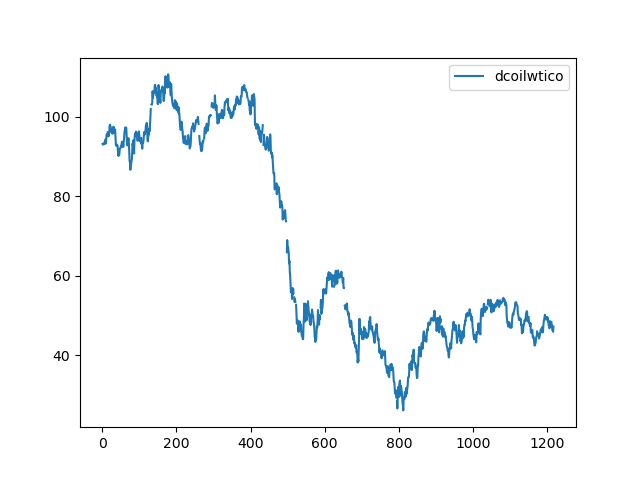

In [31]:
oil.plot()

In [3]:
train.head(20)

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0
5,5,2013-01-01,1,BREAD/BAKERY,0.0,0
6,6,2013-01-01,1,CELEBRATION,0.0,0
7,7,2013-01-01,1,CLEANING,0.0,0
8,8,2013-01-01,1,DAIRY,0.0,0
9,9,2013-01-01,1,DELI,0.0,0


<AxesSubplot:title={'center':'Productfamily HARDWARE at Store_1'}, xlabel='date'>

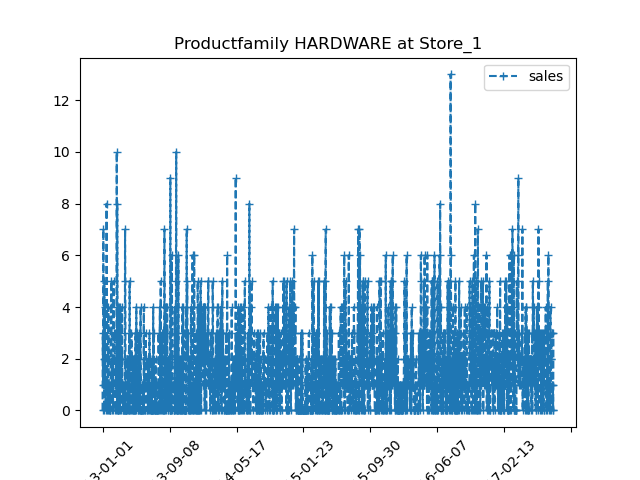

In [7]:
#plot data for one product and store
train.loc[(train['store_nbr']==1) & (train['family']=='HARDWARE')].plot('date','sales',style=['+--'],rot=45,title='Productfamily HARDWARE at Store_1')

<AxesSubplot:title={'center':'Productfamily GROCERY I at Store_3'}, xlabel='date'>

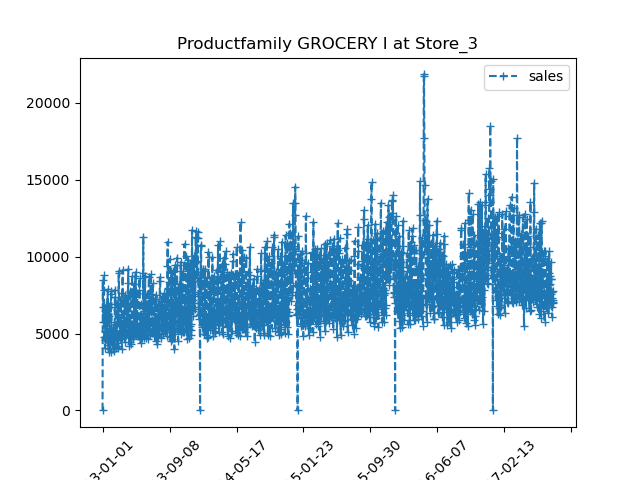

In [8]:
train.loc[(train['store_nbr']==3) & (train['family']=='GROCERY I')].plot('date','sales',style=['+--'],rot=45,title='Productfamily GROCERY I at Store_3')

In [6]:
test.head(10)

,id,date,store_nbr,family,onpromotion
0,3000888,2017-08-16,1,AUTOMOTIVE,0
1,3000889,2017-08-16,1,BABY CARE,0
2,3000890,2017-08-16,1,BEAUTY,2
3,3000891,2017-08-16,1,BEVERAGES,20
4,3000892,2017-08-16,1,BOOKS,0
5,3000893,2017-08-16,1,BREAD/BAKERY,12
6,3000894,2017-08-16,1,CELEBRATION,0
7,3000895,2017-08-16,1,CLEANING,25
8,3000896,2017-08-16,1,DAIRY,45
9,3000897,2017-08-16,1,DELI,18


### Serial dependence
Some timeseries dont seem to have a clear pattern over time but depend more on the previous behaviour. This can be checked 
by a lag plot.

In [35]:
df = train.loc[(train['store_nbr']==1) & (train['family']=='HARDWARE')]
df['Time'] = np.arange(len(df.index)) #include time dummy
df.index = list(df.date)
df = df[['Time','sales']]
y = df.loc[:,'sales']
df = pd.DataFrame({'sales':y,
                   'sales_lag_1':y.shift(1),
                  'sales_lag_2':y.shift(2)})

C:\Users\Julian\AppData\Local\Temp\ipykernel_13504\2088162330.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Time'] = np.arange(len(df.index)) #include time dummy


In [36]:
df

,sales,sales_lag_1,sales_lag_2
2013-01-01,0.0,NaN,NaN
2013-01-02,3.0,0.0,NaN
2013-01-03,1.0,3.0,0.0
2013-01-04,7.0,1.0,3.0
2013-01-05,1.0,7.0,1.0
...,...,...,...
2017-08-11,1.0,1.0,3.0
2017-08-12,0.0,1.0,1.0
2017-08-13,1.0,0.0,1.0
2017-08-14,0.0,1.0,0.0


<AxesSubplot:xlabel='sales_lag_1', ylabel='sales'>

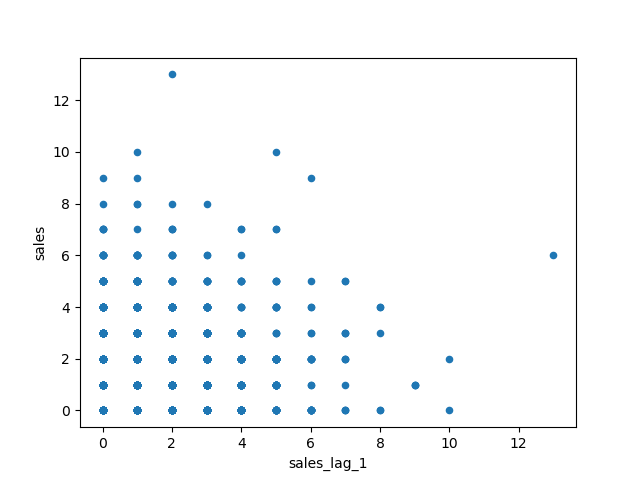

In [39]:
df.plot('sales_lag_1','sales',kind='scatter')

<AxesSubplot:xlabel='sales_lag_2', ylabel='sales'>

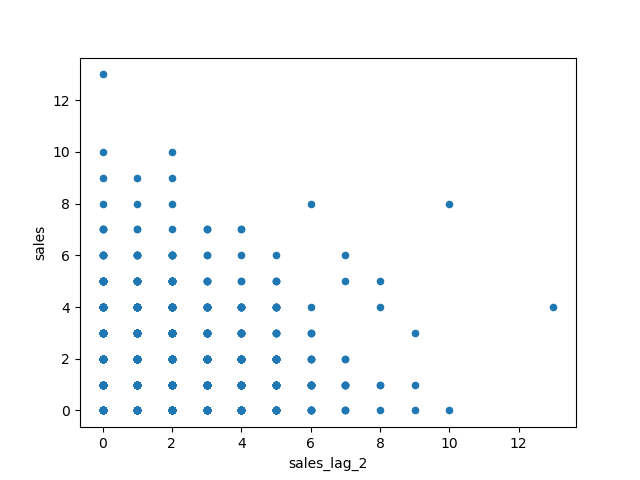

In [40]:
df.plot('sales_lag_2','sales',kind='scatter')

### Lag Plots directly using pandas

In [73]:
from pandas.plotting import lag_plot, autocorrelation_plot

In [105]:
df = train.loc[(train['store_nbr']==1) & (train['family']=='SEAFOOD')]
df['Time'] = np.arange(len(df.index)) 
df = df[['sales']]

C:\Users\Julian\AppData\Local\Temp\ipykernel_13504\4284624209.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Time'] = np.arange(len(df.index))


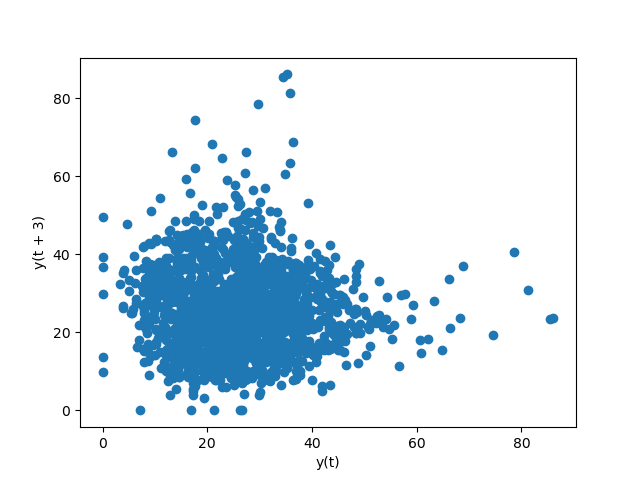

In [106]:
fig = plt.figure()
lag_plot(df,lag=3)
plt.show()

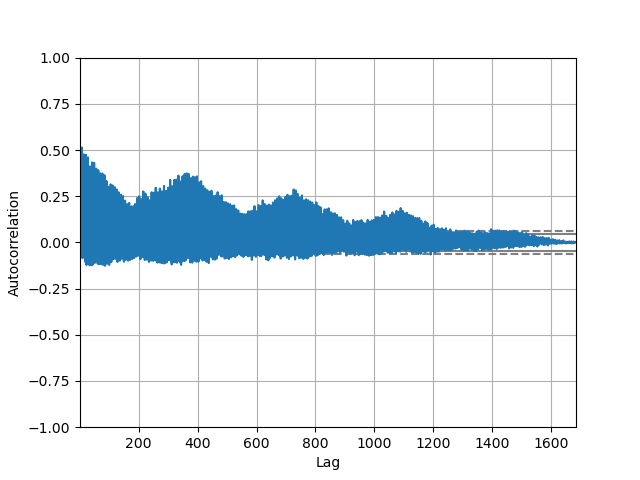

In [107]:
fig = plt.figure()
autocorrelation_plot(df)
plt.show()

### Try statsmodels Autoregression

In [77]:
from statsmodels.tsa.api import acf, graphics, pacf
from statsmodels.tsa.ar_model import AutoReg, ar_select_order

In [131]:
df = train.loc[(train['store_nbr']==1) & (train['family']=='AUTOMOTIVE')]
df['Time'] = np.arange(len(df.index)) #include time dummy
df.index = list(df.date)
df = df[['sales']]

C:\Users\Julian\AppData\Local\Temp\ipykernel_13504\4041435838.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Time'] = np.arange(len(df.index)) #include time dummy


In [132]:
df

,sales
2013-01-01,0.0
2013-01-02,2.0
2013-01-03,3.0
2013-01-04,3.0
2013-01-05,5.0
...,...
2017-08-11,1.0
2017-08-12,6.0
2017-08-13,1.0
2017-08-14,1.0


In [133]:
mod = AutoReg(df, 3, old_names=False)
res = mod.fit(cov_type='HC0')
print(res.summary())

                            AutoReg Model Results                             
Dep. Variable:                  sales   No. Observations:                 1684
Model:                     AutoReg(3)   Log Likelihood               -4076.356
Method:               Conditional MLE   S.D. of innovations              2.735
Date:                Tue, 16 Aug 2022   AIC                           8162.712
Time:                        17:51:02   BIC                           8189.848
Sample:                             3   HQIC                          8172.764
                                 1684                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.5823      0.137     18.856      0.000       2.314       2.851
sales.L1       0.0927      0.023      3.959      0.000       0.047       0.139
sales.L2       0.0316      0.023      1.350      0.1

C:\Users\Julian\anaconda3\envs\aml\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [134]:
sel = ar_select_order(np.array(df['sales']), 13, old_names='False')
sel.ar_lags
res = sel.model.fit()
print(res.summary)

<bound method AutoRegResults.summary of <statsmodels.tsa.ar_model.AutoRegResults object at 0x000002B2A7A9C880>>


C:\Users\Julian\anaconda3\envs\aml\lib\site-packages\statsmodels\tsa\ar_model.py:233: FutureWarning: old_names will be removed after the 0.14 release. You should stop setting this parameter and use the new names.
  warnings.warn(
C:\Users\Julian\anaconda3\envs\aml\lib\site-packages\statsmodels\tsa\ar_model.py:233: FutureWarning: old_names will be removed after the 0.14 release. You should stop setting this parameter and use the new names.
  warnings.warn(


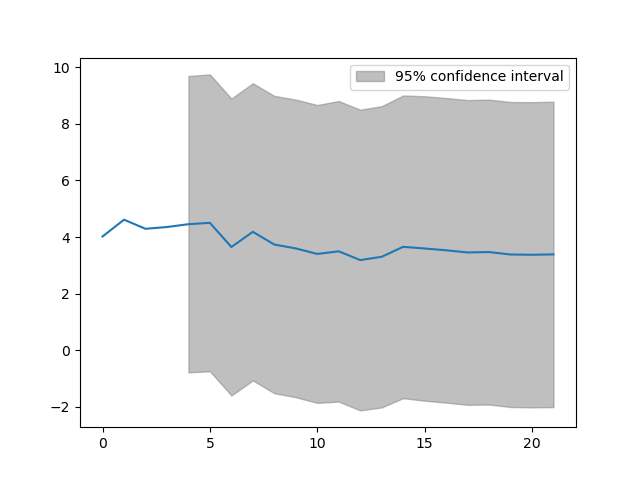

In [135]:
fig = res.plot_predict(1680,1701)